# SWR Data Analysis for ABI Visual Behavior Dataset

This notebook is designed for analyzing Sharp Wave Ripple (SWR) events in the ABI Visual Behavior dataset.
It requires the allensdk_env conda environment to be loaded.

The analysis includes:
1. Loading and exploring SWR events
2. Filtering SWR events based on quality criteria
3. Analyzing neural activity during SWR events
4. Examining the relationship between SWR events and running speed
5. Plotting running speed and pupil area around a selected SWR event

Note: Time is the unifying factor across all analyses - all data can be aligned using timestamps.


In [24]:

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import glob
from scipy.stats import mannwhitneyu
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# Configuration
CACHE_DIR = "/space/scratch/allen_visbehave_data"
SWR_INPUT_DIR = "/space/scratch/SWR_final_pipeline/osf_campbellmurphy2025_v2_final"
DATASET_NAME = "allen_visbehave_swr_murphylab2024"
SESSION_ID = 1047969464  # Example session ID

## 1. Loading and Exploring SWR Events

The SWR events are stored in compressed CSV files within session-specific folders.
The folder structure is:
```
SWR_INPUT_DIR/
└── DATASET_NAME/
    └── swrs_session_{SESSION_ID}/
        ├── probe_*_channel_*_putative_swr_events.csv.gz
        ├── probe_*_channel_*_gamma_band_events.csv.gz
        └── ...
```

Let's first look at what SWR events we have in our session.

In [25]:

# Load SWR events
session_path = os.path.join(SWR_INPUT_DIR, DATASET_NAME, f"swrs_session_{SESSION_ID}")
event_files = glob.glob(os.path.join(session_path, "probe_*_channel_*_putative_swr_events.csv.gz"))
print(f"Found {len(event_files)} SWR event files")

# Load and combine all event files
all_events = []
for event_file in event_files:
    try:
        events_df = pd.read_csv(event_file, compression='gzip')
        if not events_df.empty:
            all_events.append(events_df)
    except Exception as e:
        print(f"Warning: Could not load {event_file}: {e}")
        continue

if not all_events:
    print("No events found!")
else:
    swr_events = pd.concat(all_events, ignore_index=True)
    print("\nSWR Events Overview:")
    print(swr_events.head())
    print("\nSWR Events Info:")
    print(swr_events.info())

Found 4 SWR event files

SWR Events Overview:
   Unnamed: 0  start_time    end_time  duration  power_peak_time  \
0           0   45.342528   45.381195  0.038667        45.355195   
1           1   45.997862   46.056528  0.058667        46.035195   
2           2   57.389862   57.426528  0.036667        57.411862   
3           3  200.834528  200.865195  0.030667       200.855195   
4           4  214.967862  215.002528  0.034667       214.988528   

   power_max_zscore  power_median_zscore  power_mean_zscore  power_min_zscore  \
0          4.842641             2.543532           2.274444         -0.069833   
1          1.695311             0.827788           0.815612         -0.110837   
2          2.912046             2.232984           1.786351         -0.099563   
3          2.574397             1.376757           1.296205         -0.111150   
4          4.533467             2.756838           2.385070         -0.114900   

   power_90th_percentile  ...  envelope_median_zscore  env

In [65]:
swr_events.columns

Index(['Unnamed: 0', 'start_time', 'end_time', 'duration', 'power_peak_time',
       'power_max_zscore', 'power_median_zscore', 'power_mean_zscore',
       'power_min_zscore', 'power_90th_percentile', 'sw_exceeds_threshold',
       'sw_peak_power', 'sw_peak_time', 'sw_ripple_plv', 'sw_ripple_mi',
       'sw_ripple_clcorr', 'envelope_peak_time', 'envelope_max_thresh',
       'envelope_mean_zscore', 'envelope_median_zscore', 'envelope_max_zscore',
       'envelope_min_zscore', 'envelope_area', 'envelope_total_energy',
       'envelope_90th_percentile', 'overlaps_with_gamma',
       'gamma_overlap_percent', 'overlaps_with_movement',
       'movement_overlap_percent'],
      dtype='object')

## 2. Filtering SWR Events

Now that we have our SWR events, let's filter them based on quality criteria:
- 3SD < power_max_zscore < 10SD
- No gamma or movement overlap
- Minimum sw_peak_power > 1SD

This will help us focus on high-quality SWR events.  

In [66]:
swr_events[['power_max_zscore','power_max_zscore','overlaps_with_gamma','overlaps_with_movement','sw_peak_power']].head(10)


,power_max_zscore,power_max_zscore,overlaps_with_gamma,overlaps_with_movement,sw_peak_power
0,4.842641,4.842641,False,False,-0.574115
1,1.695311,1.695311,False,False,0.124757
2,2.912046,2.912046,False,False,-0.165992
3,2.574397,2.574397,False,False,1.220133
4,4.533467,4.533467,False,False,-0.677048
5,3.298538,3.298538,False,False,3.206380
6,6.030524,6.030524,False,False,1.742879
7,2.245120,2.245120,False,False,1.040718
8,3.388537,3.388537,False,False,-0.118756
9,9.110352,9.110352,True,False,0.487698


# Checking for Running Speed Crossings Near SWR Events

For each SWR event, we check if the running speed crosses 2 cm/s (either up or down) within ±0.25 seconds of the SWR event's peak time. This helps identify events that are closely associated with movement transitions.


In [ ]:
speed_crossings = []
mean_speeds = []
speed_threshold = 5

for _, event in swr_events.iterrows():
    # Use the actual start and end times of the event
    event_start = event['start_time']
    event_end = event['end_time']  # You'll need to use the appropriate column name
    
    # Create extended window: 0.25s before start to 0.25s after end
    t_start = event_start - 0.25
    t_end = event_end + 0.25
    
    rs = session.running_speed
    mask = (rs['timestamps'] >= t_start) & (rs['timestamps'] <= t_end)
    t_rs = rs['timestamps'][mask]
    speed = rs['speed'][mask]

    # Check if speed ever goes above 2 cm/s in the extended window
    speed_above_threshold = np.any(speed > speed_threshold) if len(speed) > 0 else False
    speed_crossings.append(speed_above_threshold)

    # Compute mean speed over just the event duration (not the extended window)
    event_mask = (rs['timestamps'] >= event_start) & (rs['timestamps'] <= event_end)
    event_speed = rs['speed'][event_mask]
    mean_speeds.append(event_speed.mean() if len(event_speed) > 0 else np.nan)

swr_events['speed_above_threshold'] = speed_crossings
swr_events['mean_speed'] = mean_speeds

n_cross = sum(speed_crossings)
print(f"Number of putative SWR events with speed above 2 cm/s within extended window: {n_cross} / {len(swr_events)}")


In [ ]:
# Filter events
filtered_events = swr_events[
    (swr_events['power_max_zscore'] > 3) & 
    (swr_events['power_max_zscore'] < 10) &
    (~swr_events['overlaps_with_gamma']) &
    (~swr_events['overlaps_with_movement']) &
    (swr_events['sw_peak_power'] > 1) &
    (swr_events['speed_above_threshold'] == False)  # Changed from speed_crosses_2cm
].copy()

print(f"\nTotal events: {len(swr_events)}")
print(f"Filtered events: {len(filtered_events)}")

# Look at summary statistics of filtered events
print("\nFiltered Events Summary:")
print(filtered_events[['start_time', 'end_time','power_max_zscore', 'sw_peak_power', 'mean_speed']].head(10))


Total events: 15945
Filtered events: 272

Filtered Events Summary:
       start_time     end_time  power_max_zscore  sw_peak_power  mean_speed
740   2895.459195  2895.526528          3.638459       1.462943   -0.114991
1069  3445.937195  3446.073195          4.105435       2.030828    1.012583
1407  4462.533195  4462.573195          4.653862       1.184521    0.595241
1624  5176.626528  5176.688528          4.578893       1.282910         NaN
3343  8792.047862  8792.129195          6.691374       1.645272         NaN
3345  8794.149862  8794.238528          7.794229       3.235609         NaN
3346  8795.633862  8795.763862          4.433045       1.176864         NaN
3348  8799.887862  8799.969195          3.887927       4.501442         NaN
3352  8802.528528  8802.637195          3.183473       4.663082         NaN
3353  8802.810528  8802.863862          3.044580       1.669558         NaN


In [87]:
# Debug: Look at a specific event with high mean speed
debug_event = filtered_events.iloc[6]  # The one with mean_speed = 78.9
print(f"Debug event: start={debug_event['start_time']:.3f}, end={debug_event['end_time']:.3f}")
print(f"Mean speed: {debug_event['mean_speed']:.2f}")
print(f"Speed crosses 2cm: {debug_event['speed_crosses_2cm']}")

# Get the speed data for this event
event_start = debug_event['start_time']
event_end = debug_event['end_time']
t_start_extended = event_start - 0.25
t_end_extended = event_end + 0.25

rs = session.running_speed
mask_extended = (rs['timestamps'] >= t_start_extended) & (rs['timestamps'] <= t_end_extended)
mask_event = (rs['timestamps'] >= event_start) & (rs['timestamps'] <= event_end)

speed_extended = rs['speed'][mask_extended]
speed_event = rs['speed'][mask_event]

print(f"Speed during extended window: min={speed_extended.min():.2f}, max={speed_extended.max():.2f}")
print(f"Speed during event: min={speed_event.min():.2f}, max={speed_event.max():.2f}")
print(f"Extended window speeds: {speed_extended.values}")

Debug event: start=8795.634, end=8795.764
Mean speed: nan
Speed crosses 2cm: False
Speed during extended window: min=nan, max=nan
Speed during event: min=nan, max=nan
Extended window speeds: []


## 2. Plotting Running Speed and Pupil Area Around a SWR Event

SWRs tend to occur during periods of slowed movement or immobility and are typically coupled with pupil contraction.

Below, we visualize running speed and pupil area in a window around a selected SWR event.

Let's create a function to visualize running speed and pupil area (if available) in a window around a selected SWR event. This will help us see the behavioral state and pupil changes during SWRs, similar to the example plot you provided.

The plot will:
- Zoom in around the SWR event (default ±1s, configurable)
- Plot running speed and pupil area (z-scored) on dual y-axes
- Shade the SWR event and mark the SWR peak
- Include a legend and clear axis labels

For more details on aligning behavioral data, see:
[Aligning Behavioral Data to Task Events](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/aligning_behavioral_data_to_task_events_with_the_stimulus_and_trials_tables.html)


In [88]:

def plot_swr_event_with_behavior(session, event, window=1.0):
    """
    Plot running speed and pupil area (z-scored) around a single SWR event.
    - session: AllenSDK session object
    - event: row from filtered_events DataFrame
    - window: seconds before/after event to plot
    """
    # Get time window
    t0 = event['power_peak_time'] if not np.isnan(event['power_peak_time']) else event['start_time']
    t_start = t0 - window
    t_end = t0 + window

    # Running speed
    rs = session.running_speed
    mask = (rs['timestamps'] >= t_start) & (rs['timestamps'] <= t_end)
    t_rs = rs['timestamps'][mask]
    speed = rs['speed'][mask]

    # Pupil area (z-scored)
    pupil = None
    pupil_z = None
    t_pupil = None
    pupil_gap_warning = False
    if hasattr(session, 'eye_tracking') and session.eye_tracking is not None:
        et = session.eye_tracking
        # Use 'pupil_area' or 'pupil_area_raw' if available
        pupil_col = None
        for col in ['pupil_area', 'pupil_area_raw']:
            if col in et.columns:
                pupil_col = col
                break
        if pupil_col is not None:
            t_et = et['timestamps']
            mask_et = (t_et >= t_start) & (t_et <= t_end)
            pupil = et[pupil_col][mask_et]
            t_pupil = t_et[mask_et]
            # Check for missing data
            if len(t_pupil) > 1:
                time_gaps = np.diff(t_pupil)
                max_gap = np.max(time_gaps)
                if max_gap > 2 * np.median(time_gaps):
                    print(f"Warning: Large gap in pupil data: {max_gap:.3f} s")
                    pupil_gap_warning = True
            if pupil.isnull().any():
                print(f"Warning: {pupil.isnull().sum()} missing pupil values in window.")
            # Only plot if enough data
            if pupil.notnull().sum() > 2:
                pupil_z = (pupil - np.nanmean(pupil)) / np.nanstd(pupil)
            else:
                print("Warning: Not enough valid pupil data to plot.")
                pupil = None
        else:
            print("Warning: No pupil area column found in eye_tracking data.")
    else:
        print("Warning: No eye_tracking data available in session.")

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(t_rs, speed, color='orange', label='Running speed')
    ax1.set_ylabel('Running speed (cm/s)', color='black')
    ax1.set_xlabel('Experiment time (s)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Plot pupil on second axis if available
    if pupil_z is not None and t_pupil is not None:
        ax2 = ax1.twinx()
        ax2.plot(t_pupil, pupil_z, color='green', label='Pupil (z)')
        ax2.set_ylabel('Pupil area (z-score)', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
    
    # Shade SWR event
    ax1.axvspan(event['start_time'], event['end_time'], color='C4', alpha=0.2, label='SWR event')
    # Mark SWR peak
    if not np.isnan(event['power_peak_time']):
        ax1.axvline(event['power_peak_time'], color='k', linestyle=':', label='SWR peak')
    
    # Title and legend
    session_id = getattr(session, 'ecephys_session_id', None)
    if session_id is None:
        session_id = getattr(session, 'id', 'unknown')
    n_swrs = 1
    ax1.set_title(f"Session {session_id} | SWR at {t0:.2f}s | {n_swrs} SWRs in window")
    lines, labels = ax1.get_legend_handles_labels()
    if pupil_z is not None and t_pupil is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines += lines2
        labels += labels2
    # Place legend below the plot
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.margins(x=0)  # Remove horizontal margin
    plt.show()


Now you can cycle through the events, note though that the pupil data has a lot of gaps in the data in may sessions.

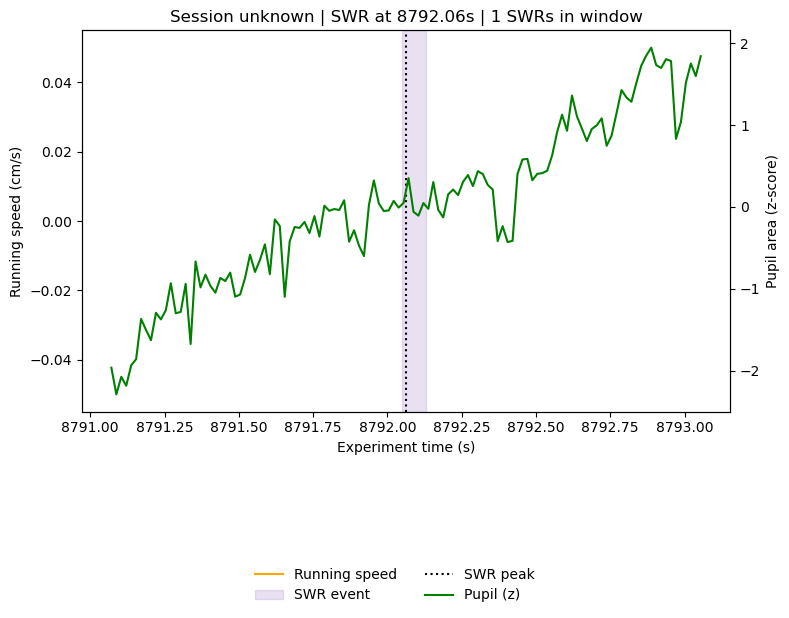

In [92]:

# Example: Plot running speed and pupil area for a single SWR event
example_event = filtered_events.iloc[4]
plot_swr_event_with_behavior(session, example_event, window=1.0) 

## 3. Analyzing Neural Activity During SWR Events

For more information about the units data structure and analysis, see the 
[Visual Behavior Neuropixels Dataset Manifest](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_neuropixels_dataset_manifest.html)

Let's first look at what units we have in our session.

In [56]:

# Load session and units
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=CACHE_DIR)
session = cache.get_ecephys_session(SESSION_ID)
units = cache.get_unit_table()

# Filter for this session
session_units = units[units['ecephys_session_id'] == SESSION_ID]
print("\nUnits Table Overview:")
print(session_units.head())
print("\nUnits per region:")
print(session_units['structure_acronym'].value_counts())

# Filter for good CA1 units
ca1_units = session_units[
    (session_units['structure_acronym'] == 'CA1') &
    (session_units['quality'] == 'good') &
    (session_units['valid_data'] == True)
]
print(f"\nNumber of good CA1 units: {len(ca1_units)}")

/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)



Units Table Overview:
            ecephys_channel_id  ecephys_probe_id  ecephys_session_id  \
unit_id                                                                
1179688669          1049367342        1048089915          1047969464   
1179688297          1049367342        1048089915          1047969464   
1179688700          1049367178        1048089915          1047969464   
1179688698          1049367178        1048089915          1047969464   
1179688604          1049367178        1048089915          1047969464   

            amplitude_cutoff  anterior_posterior_ccf_coordinate  \
unit_id                                                           
1179688669          0.004630                             8522.0   
1179688297          0.003084                             8522.0   
1179688700          0.019765                             8638.0   
1179688698          0.490989                             8638.0   
1179688604          0.215032                             8638.0   

  

Now let's analyze how these units respond to SWR events. We'll create a heatmap showing the normalized, 
z-scored firing rates around SWR peaks. This will help us visualize which units increase or decrease 
their firing during SWRs.

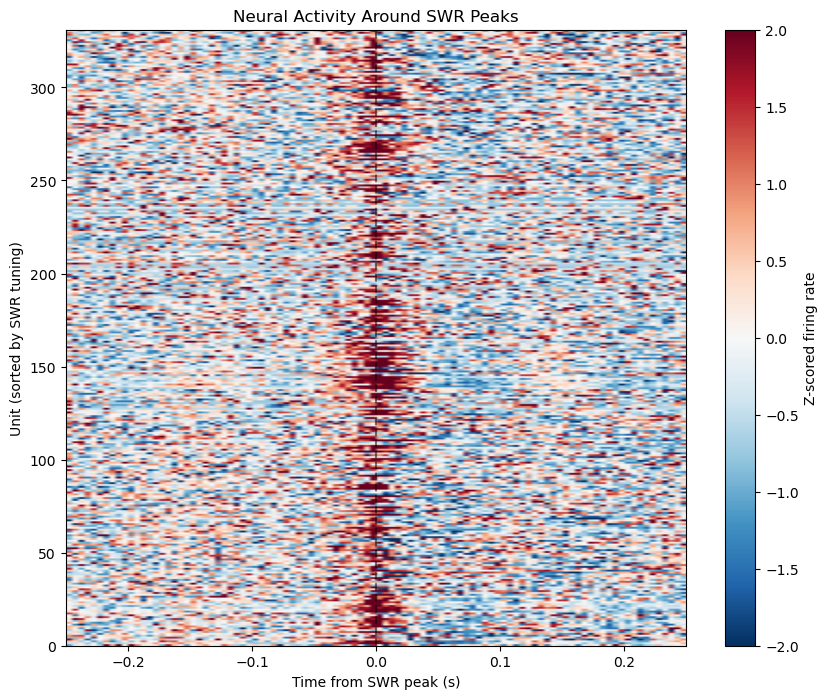

In [57]:

def plot_swr_heatmap(session, events_df, unit_ids, window=0.25, bin_size=0.005):
    """Create a heatmap of normalized, z-scored firing rates around SWR peaks."""
    # Create time bins
    time_bins = np.arange(-window, window + bin_size, bin_size)
    
    # Initialize array for firing rates
    n_units = len(unit_ids)
    n_bins = len(time_bins) - 1
    firing_rates = np.zeros((n_units, n_bins))
    
    # Calculate firing rates for each unit
    for i, unit_id in enumerate(unit_ids):
        spikes = session.spike_times[unit_id]
        
        # Get spikes around each SWR peak
        for _, event in events_df.iterrows():
            if not np.isnan(event['power_peak_time']):
                peak_time = event['power_peak_time']
                # Get spikes within window of peak
                event_spikes = spikes[
                    (spikes >= peak_time - window) & 
                    (spikes <= peak_time + window)
                ]
                # Bin spikes
                hist, _ = np.histogram(event_spikes - peak_time, bins=time_bins)
                firing_rates[i] += hist
    
    # Normalize by total spikes per unit
    row_sums = firing_rates.sum(axis=1)
    firing_rates = firing_rates / row_sums[:, np.newaxis]
    
    # Z-score each row
    firing_rates = (firing_rates - firing_rates.mean(axis=1)[:, np.newaxis]) / firing_rates.std(axis=1)[:, np.newaxis]
    
    # Sort units by their SWR tuning (mean z-score during SWR)
    swr_tuning = firing_rates.mean(axis=1)
    sort_idx = np.argsort(swr_tuning)[::-1]  # Sort in descending order
    firing_rates = firing_rates[sort_idx]
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(firing_rates, 
               aspect='auto',
               cmap='RdBu_r',
               extent=[-window, window, 0, n_units],
               vmin=-2, vmax=2)
    
    plt.colorbar(label='Z-scored firing rate')
    plt.xlabel('Time from SWR peak (s)')
    plt.ylabel('Unit (sorted by SWR tuning)')
    plt.title('Neural Activity Around SWR Peaks')
    
    # Add vertical line at SWR peak
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    
    plt.show()

# Plot the heatmap
plot_swr_heatmap(session, filtered_events, ca1_units.index)

Here we rank CA1 neurons by their response to SWR events using the Mann-Whitney U test. For each neuron, we compare its firing rate during SWR events to its baseline firing rate outside of SWRs. 

- **Effect size**: The difference in mean firing rate (Hz) during SWRs minus baseline.
- **p-value**: The probability that the observed difference is due to chance (from the Mann-Whitney U test).

We rank neurons as follows:
- Significant positive responders (effect > 0, p < 0.05) at the top
- Non-significant responders (p >= 0.05) in the middle
- Significant negative responders (effect < 0, p < 0.05) at the bottom

This helps identify neurons that are excited or inhibited by SWRs.

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def mannwhitney_swr_ranking(session, unit_ids, events_df, bin_size=0.01):
    # Find the maximum spike time across all units
    max_time = max(session.spike_times[uid].max() if len(session.spike_times[uid]) > 0 else 0 for uid in unit_ids)
    n_bins = int(np.ceil(max_time / bin_size)) + 1

    # Build a global SWR mask
    swr_mask = np.zeros(n_bins, dtype=bool)
    for _, event in events_df.iterrows():
        start_bin = int(event['start_time'] / bin_size)
        end_bin = int(event['end_time'] / bin_size)
        swr_mask[start_bin:end_bin] = True

    results = []
    for unit_id in unit_ids:
        spikes = session.spike_times[unit_id]
        spike_counts, _ = np.histogram(spikes, bins=np.arange(0, (n_bins+1) * bin_size, bin_size))

        # Truncate mask or spike_counts to match in case of rounding issues
        min_len = min(len(spike_counts), len(swr_mask))
        spike_counts = spike_counts[:min_len]
        mask = swr_mask[:min_len]

        swr_fr = spike_counts[mask] / bin_size
        base_fr = spike_counts[~mask] / bin_size

        if len(swr_fr) > 0 and len(base_fr) > 0:
            stat, pval = mannwhitneyu(swr_fr, base_fr, alternative='two-sided')
            effect = swr_fr.mean() - base_fr.mean()
        else:
            pval = np.nan
            effect = np.nan

        results.append({'unit_id': unit_id, 'effect': effect, 'pval': pval})

    results_df = pd.DataFrame(results)

    # Benjamini–Hochberg correction (ignores NaNs)
    mask_valid = results_df['pval'].notna()
    _, qvals, _, _ = multipletests(results_df.loc[mask_valid, 'pval'], method='fdr_bh')
    results_df.loc[mask_valid, 'qval'] = qvals
    results_df.loc[~mask_valid, 'qval'] = np.nan

    return results_df

swr_ranking = mannwhitney_swr_ranking(session, ca1_units.index, filtered_events)
ca1_units_ranked = ca1_units.copy()
ca1_units_ranked = ca1_units_ranked.merge(swr_ranking, left_index=True, right_on='unit_id')

# Rank: significant positive, then non-significant, then significant negative
sig_pos = (ca1_units_ranked['effect'] > 0) & (ca1_units_ranked['qval'] < 0.05)
sig_neg = (ca1_units_ranked['effect'] < 0) & (ca1_units_ranked['qval'] < 0.05)
non_sig = ~(sig_pos | sig_neg)
ca1_units_ranked['rank_group'] = 1 * sig_pos + 2 * non_sig + 3 * sig_neg
ca1_units_ranked = ca1_units_ranked.sort_values(['rank_group', 'effect'], ascending=[True, False])

print("Top CA1 units by SWR responsiveness (effect size and p-value):")
display_cols = ['effect', 'pval', 'firing_rate', 'unit_id', 'quality', 'valid_data']
print(ca1_units_ranked[display_cols].head(10))

Top CA1 units by SWR responsiveness (effect size and p-value):
        effect           pval  firing_rate     unit_id quality  valid_data
14   17.163488   0.000000e+00    28.518569  1179688261    good        True
26   16.791848   0.000000e+00    10.339859  1179688337    good        True
125  11.935696  1.841045e-283    19.013122  1179689083    good        True
169  10.536674  5.121243e-128    42.291126  1179687327    good        True
150   9.831767  7.917899e-248    13.855645  1179687353    good        True
193   9.796357   0.000000e+00     4.110292  1179687303    good        True
110   9.177193   0.000000e+00     5.182452  1179689041    good        True
297   7.225549   1.756073e-83    28.379501  1179685334    good        True
85    6.337254  7.403093e-109    15.452824  1179689085    good        True
111   5.655549  1.517605e-134     8.648534  1179689040    good        True


Calling the mean difference an "effect" is a bit of a stretch but it works for our purposes to perform a quick EDA of the data. Note we have also computed

In [62]:
# Rank: significant positive, then non-significant, then significant negative
sig_pos = (ca1_units_ranked['effect'] > 0) & (ca1_units_ranked['qval'] < 0.05)
sig_neg = (ca1_units_ranked['effect'] < 0) & (ca1_units_ranked['qval'] < 0.05)
non_sig = ~(sig_pos | sig_neg)
ca1_units_ranked['rank_group'] = 1 * sig_pos + 2 * non_sig + 3 * sig_neg
ca1_units_ranked = ca1_units_ranked.sort_values(['rank_group', 'effect'], ascending=[True, False])

print("Top CA1 units by SWR responsiveness (effect size and p-value):")
display_cols = ['effect', 'pval','qval', 'firing_rate', 'unit_id', 'quality', 'valid_data']
print(ca1_units_ranked[display_cols].head(10))

Top CA1 units by SWR responsiveness (effect size and p-value):
        effect           pval           qval  firing_rate     unit_id quality  \
14   17.163488   0.000000e+00   0.000000e+00    28.518569  1179688261    good   
26   16.791848   0.000000e+00   0.000000e+00    10.339859  1179688337    good   
125  11.935696  1.841045e-283  1.218772e-281    19.013122  1179689083    good   
169  10.536674  5.121243e-128  1.130088e-126    42.291126  1179687327    good   
150   9.831767  7.917899e-248  3.744035e-246    13.855645  1179687353    good   
193   9.796357   0.000000e+00   0.000000e+00     4.110292  1179687303    good   
110   9.177193   0.000000e+00   0.000000e+00     5.182452  1179689041    good   
297   7.225549   1.756073e-83   2.004346e-82    28.379501  1179685334    good   
85    6.337254  7.403093e-109  1.361347e-107    15.452824  1179689085    good   
111   5.655549  1.517605e-134  3.588053e-133     8.648534  1179689040    good   

     valid_data  
14         True  
26       

# Heatmap of CA1 Neurons Ordered by SWR Responsiveness

Below, we plot the heatmap of neural activity around SWR peaks, with neurons ordered by their SWR responsiveness (effect size and p-value from the Mann-Whitney U test).


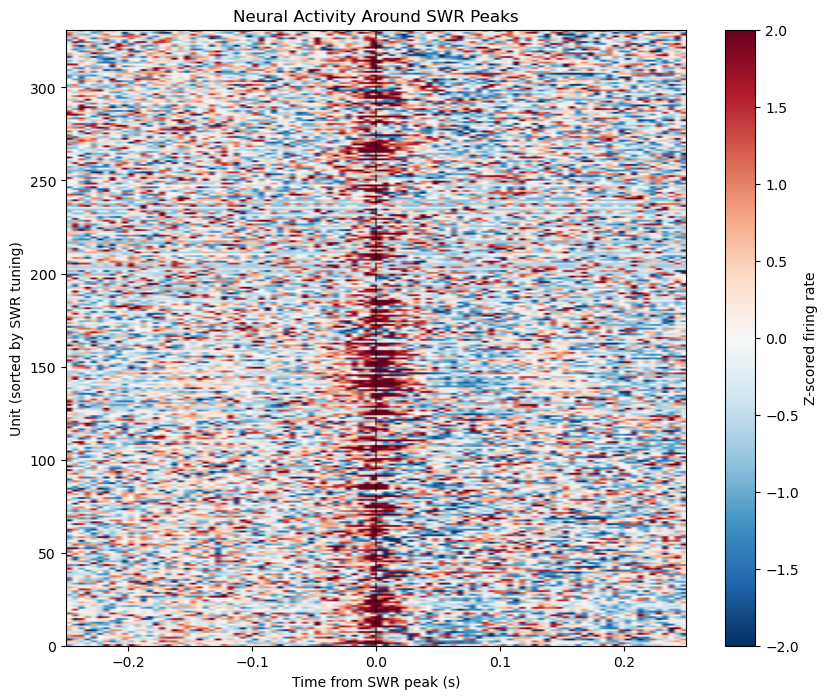

In [63]:
plot_swr_heatmap(session, filtered_events, ca1_units_ranked['unit_id'])

# Peristimulus Time Histogram (PSTH) for the Most Significant Positively Tuned Neuron

A peristimulus time histogram (PSTH) shows the average firing rate of a neuron aligned to SWR peaks. Here, we plot the PSTH for the most significant positively tuned CA1 neuron, using a ±0.5s window around each SWR peak.



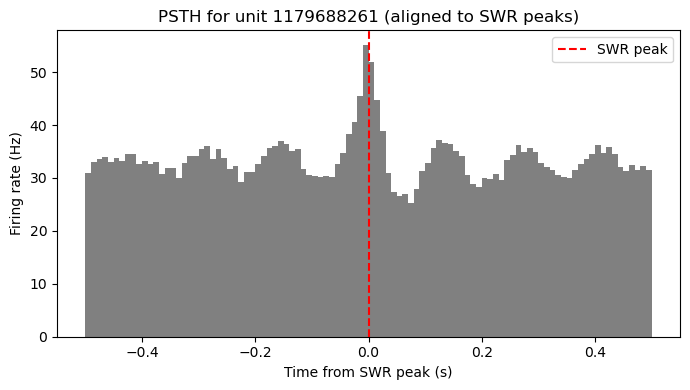

In [64]:

def plot_psth_for_unit(session, events_df, unit_id, window=0.5, bin_size=0.01):
    spikes = session.spike_times[unit_id]
    event_peaks = events_df['power_peak_time'].dropna().values
    peri_spike_times = []
    for peak in event_peaks:
        peri_spike_times.extend(spikes[(spikes >= peak - window) & (spikes <= peak + window)] - peak)
    peri_spike_times = np.array(peri_spike_times)
    bins = np.arange(-window, window + bin_size, bin_size)
    counts, _ = np.histogram(peri_spike_times, bins=bins)
    psth = counts / (len(event_peaks) * bin_size)
    plt.figure(figsize=(7,4))
    plt.bar(bins[:-1], psth, width=bin_size, color='gray', align='edge')
    plt.axvline(0, color='red', linestyle='--', label='SWR peak')
    plt.xlabel('Time from SWR peak (s)')
    plt.ylabel('Firing rate (Hz)')
    plt.title(f'PSTH for unit {unit_id} (aligned to SWR peaks)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Find the most significant positively tuned neuron
most_sig_pos = ca1_units_ranked[(ca1_units_ranked['effect'] > 0)].sort_values('pval')

best_unit = most_sig_pos.iloc[0]['unit_id']

plot_psth_for_unit(session, filtered_events, best_unit, window=0.5, bin_size=0.01)